# Perkenalan

Nama : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

Data set overview :

Objective : 

# Import Libraries

In [1]:
# Data Loading
import os
import glob
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
print('Tensorflow version', tf.__version__)


Tensorflow version 2.10.0


# Data Loading

In [2]:
# Download the data set
!kaggle datasets download chrisfilo/fruit-recognition

fruit-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Unzip the data set
# -q = quiet mode
# -n never overwrite existing files
# -o overwrite fies WITHOUT prompting
# -d exdir
!unzip -q -n fruit-recognition.zip -d ./data

In [4]:
# Get kind of fruits
print(os.listdir('./data/'))

['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes']


In [5]:
# Get Apple sub-categories
# folder 'Total Number of Apples' is similar to folder '
print(os.listdir('./data/Apple/'))

['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F', 'Total Number of Apples']


In [6]:
# Get Apple images
print(os.listdir('./data/Apple/Apple A')[:5])
# Get Banana images
print(os.listdir('./data/Banana/')[:5])

['Apple 1.png', 'Apple 10.png', 'Apple 100.png', 'Apple 101.png', 'Apple 102.png']
['71Banana02034.png', '79Banana02063.png', '87Banana02109.png', 'Banana01.png', 'Banana010.png']


TODO
- [ ] Do EDA on Apple, Guava, Kiwi sub-categories.

In [7]:
# Get kind of fruits and its sub-categories
def isolate():
    kinds = os.listdir('./data/')
    print("kinds", kinds)
    for kind in kinds:
        sub_categories = [path for path in os.listdir('./data/'+kind) 
                          if os.path.isdir('./data/'+kind+'/'+path)]
        if len(sub_categories) != 0:
            print("sub-categories of", kind, sub_categories)
    
isolate()

kinds ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes']
sub-categories of Apple ['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F', 'Total Number of Apples']
sub-categories of Guava ['guava A', 'guava B', 'Guava total', 'guava total final']
sub-categories of Kiwi ['kiwi A', 'Kiwi B', 'Kiwi C', 'Total Number of Kiwi fruit']


In [8]:
# Load the data set
def isolate():
    global df
    
    data = []
    
    kinds = os.listdir('./data/')
    for kind in kinds:
        sub_categories = [path for path in os.listdir(f'./data/{kind}')
                          if os.path.isdir(f'./data/{kind}/{path}')]
        # ./data/Apple/Apple A -> sub_categories = ['Apple A']
        # ./data/Banana/71Banana02034.png -> sub_categories = []
        for sub_category in sub_categories:
            data += [[sub_category, path] for path in 
                     glob.glob(pathname=f'./data/{kind}/{sub_category}/*.png')]
            continue
        
        data += [[kind, path] for path in glob.glob(pathname=f'./data/{kind}/*.png')]
            
    df = pd.DataFrame(data=data, columns=['kind', 'path'])
    
isolate()

In [9]:
# Preview the data set
df.head()

,kind,path
0,Apple A,./data/Apple/Apple A/Apple 1.png
1,Apple A,./data/Apple/Apple A/Apple 10.png
2,Apple A,./data/Apple/Apple A/Apple 100.png
3,Apple A,./data/Apple/Apple A/Apple 101.png
4,Apple A,./data/Apple/Apple A/Apple 102.png


# Functions

In [10]:
# visualize each sub categories with 3 samples.
def imshow_kind(data=df, kind='Apple'):
    samples = data[data['kind'].str.contains(kind, case=False)] \
        .groupby(by='kind').sample(3, random_state=None)
    
    fig, axes = plt.subplots(
        nrows=len(samples['kind'].unique()), ncols=3, figsize=(10,10), 
        layout='constrained')
    for (_, sample), ax in zip(samples.iterrows(), axes.ravel()):
        img = mpimg.imread(sample['path'])
        ax.imshow(img)
        ax.set_title("/".join(sample['path'].split('/')[-2:]))

# Exploratory Data Analysis

In [11]:
# Duplicate the data set
df_a = df.copy()

IMPORTANT
- Do not use folder 'Total Number of Apples' to train

  The folder contains mutiple sub-categories of Apple.

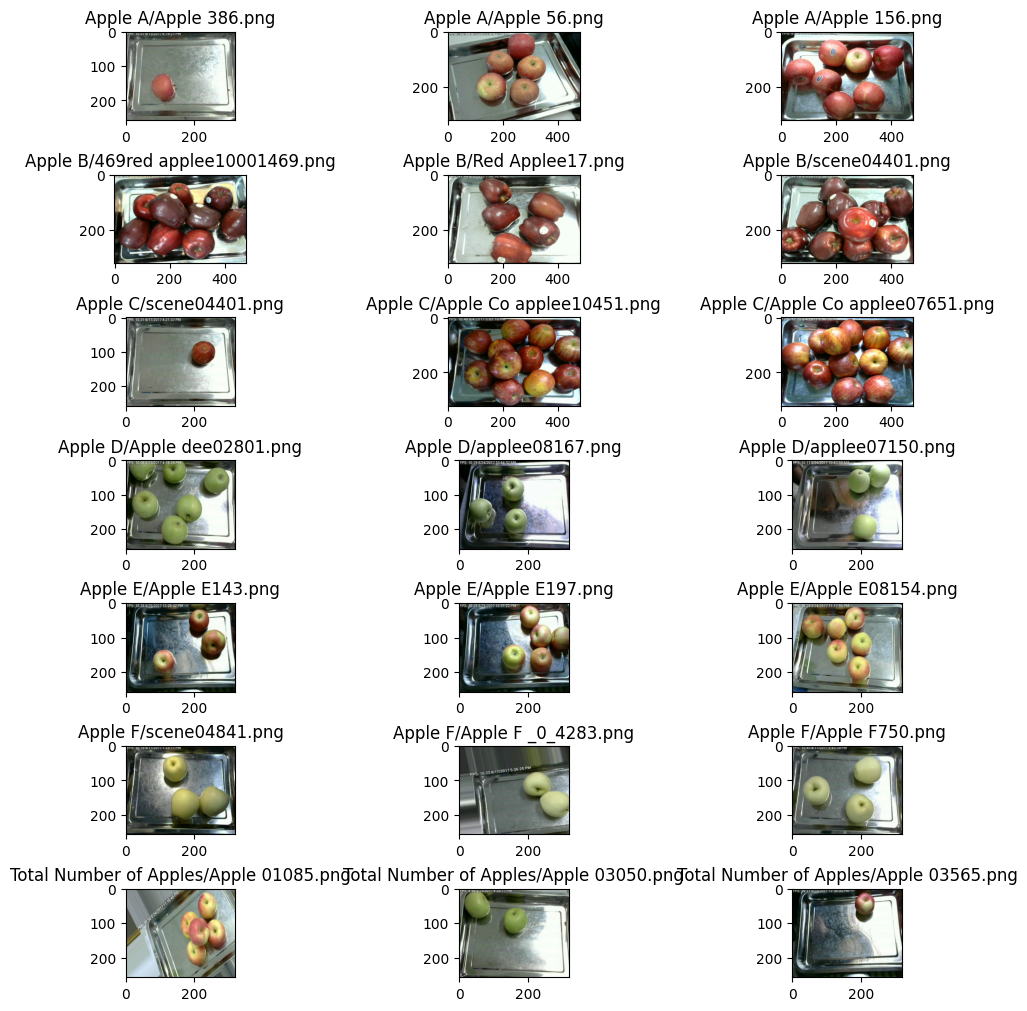

In [12]:
imshow_kind(data=df_a, kind='Apple')

In [13]:
# drop kind 'Total Number of Apples'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Apples'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

IMPORTANT
- Do not use folder 'Guava total' and 'Guava total final'
  
  We can't distinguish folder 'Guava total' and 'guava total final'

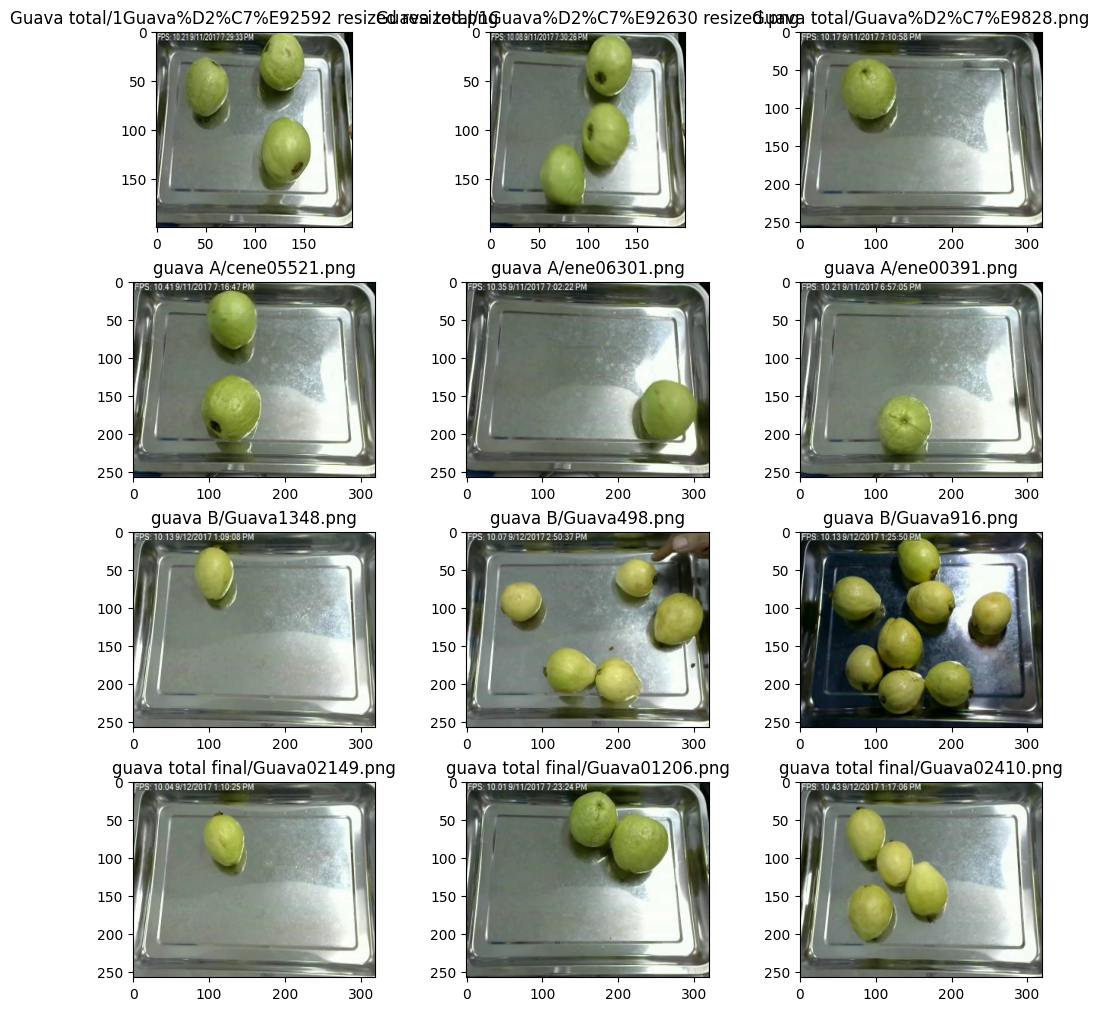

In [14]:
imshow_kind(data=df_a, kind='Guava')

In [15]:
# Drop kind 'Guava total', 'guava total final'
def isolate():
    indicies = df_a[df_a['kind'].isin(['Guava total', 'guava total final'])].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

IMPORTANT
- Do not use folder 'Total Number of Kiwi fruit'

  The folder contains multiple sub-categories of Kiwi.

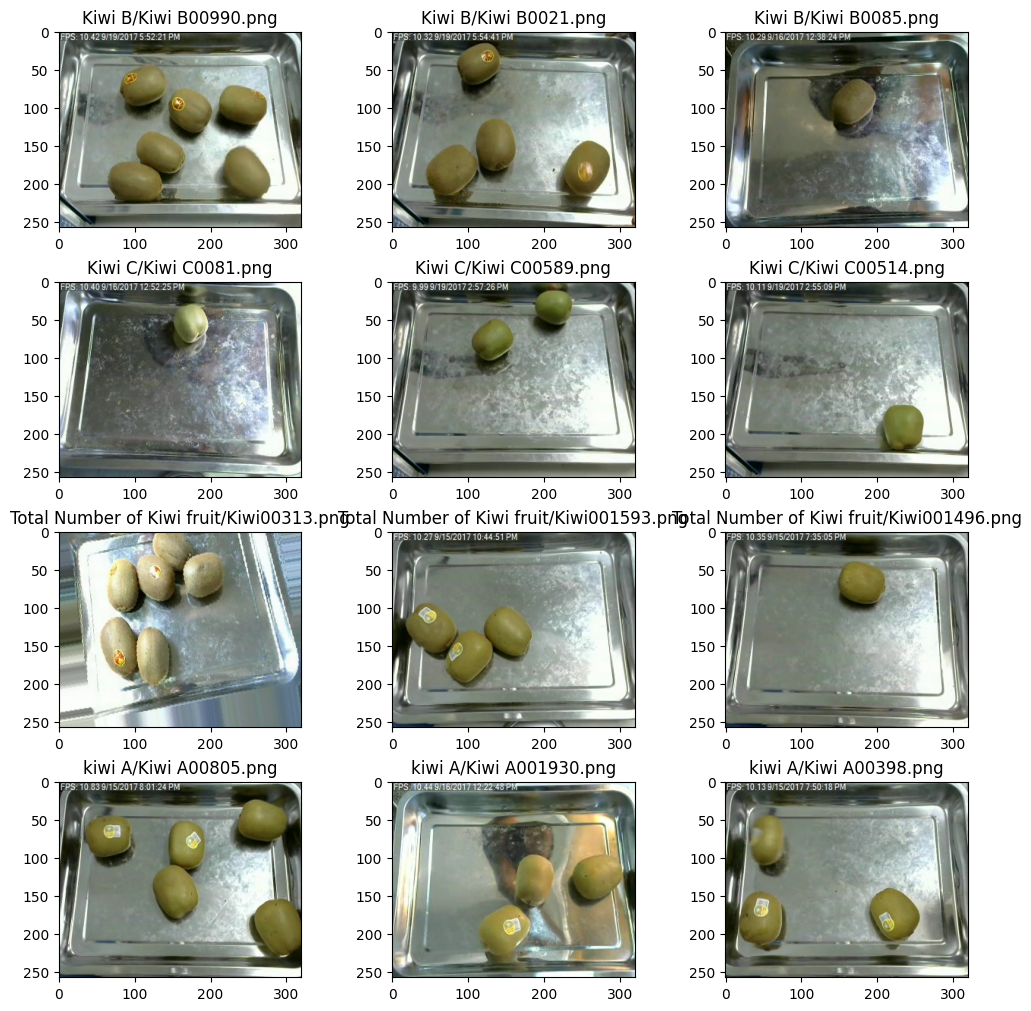

In [16]:
imshow_kind(data=df_a, kind='Kiwi')

In [17]:
# drop kind 'Total Number of Kiwi fruit'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Kiwi fruit'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()